# Final Report
## CSE627 Project1: PUBG Finish Placement Prediction
by Chen Wang & Tommy Bojanin

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

## Data Exploration

In [26]:
training_data = pd.read_csv('./input/train_V2.csv')
testing_data = pd.read_csv('./input/test_V2.csv')

In [27]:
raw_training_data = training_data.copy() # a copy of orriginal training data
raw_testing_data = testing_data.copy() # a copy of original training data

In [28]:
print("The shape of training data set is:{}".format(training_data.shape))
print("The shape of testing data set is:{}".format(testing_data.shape))

The shape of training data set is:(4446966, 29)
The shape of testing data set is:(1934174, 28)


We can tell that datasets associated with this kaggle problem are pretty large (training set contains over 4 million records). Thus some complex kernel methods for regression can take incredibly long time to fit. We may sample the original training set in the following model building procedures. 

In [29]:
record_ids = list(testing_data['Id']) # sample id in testing data

First we check whether there is any missing value in our training data

In [30]:
pd.isnull(training_data).sum()>0

Id                 False
groupId            False
matchId            False
assists            False
boosts             False
damageDealt        False
DBNOs              False
headshotKills      False
heals              False
killPlace          False
killPoints         False
kills              False
killStreaks        False
longestKill        False
matchDuration      False
matchType          False
maxPlace           False
numGroups          False
rankPoints         False
revives            False
rideDistance       False
roadKills          False
swimDistance       False
teamKills          False
vehicleDestroys    False
walkDistance       False
weaponsAcquired    False
winPoints          False
winPlacePerc        True
dtype: bool

Missing values are detected in the response variable "winPlacePerc", we then pull out the observations that contain missing values

In [31]:
training_data.loc[training_data.winPlacePerc.isna()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [32]:
training_data.iloc[2744604,]

Id                 f70c74418bb064
groupId            12dfbede33f92b
matchId            224a123c53e008
assists                         0
boosts                          0
damageDealt                     0
DBNOs                           0
headshotKills                   0
heals                           0
killPlace                       1
killPoints                      0
kills                           0
killStreaks                     0
longestKill                     0
matchDuration                   9
matchType                solo-fpp
maxPlace                        1
numGroups                       1
rankPoints                   1574
revives                         0
rideDistance                    0
roadKills                       0
swimDistance                    0
teamKills                       0
vehicleDestroys                 0
walkDistance                    0
weaponsAcquired                 0
winPoints                       0
winPlacePerc                  NaN
Name: 2744604,

Obviously, the record of this observation is unreasonable. For example most of the game statistics are 0 and numGroups is only one. Thus we decide to simply drop this game record.

In [33]:
training_data = training_data.dropna()

We then check shapes of training and testing data set and get descriptive statistics for all continuous variables

In [34]:
training_data.shape

(4446965, 29)

In [35]:
testing_data.shape

(1934174, 28)

In [36]:
training_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [37]:
testing_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [38]:
training_data.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,...,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06
mean,2.338150e-01,1.106908e+00,1.307172e+02,6.578757e-01,2.268196e-01,1.370148e+00,4.759936e+01,5.050062e+02,9.247835e-01,5.439553e-01,...,1.646590e-01,6.061158e+02,3.496092e-03,4.509323e+00,2.386841e-02,7.918209e-03,1.154218e+03,3.660488e+00,6.064603e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746293e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261158e-02,1.183497e+03,2.456543e+00,7.397005e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.910000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


We then further explore the training dataset in detail by first checking the distribution of the response variable "winPlacePerc"

Text(0,0.5,'counts')

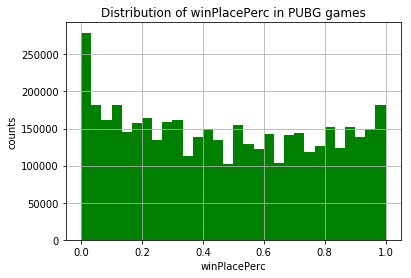

In [39]:
target = training_data["winPlacePerc"]
target.hist(bins=30,color = "green")
plt.title("Distribution of winPlacePerc in PUBG games")
plt.xlabel("winPlacePerc")
plt.ylabel("counts")

We expect that our response varible would follow a uniform distribution but the histagram shows that more observations are enriched in head and tail area, especaially the head. This imbalance in the distribution of the response variable may be due to the mix of match types in game records. Thus we will further explore the match type variable in the training dataset.

In [40]:
training_data["matchType"].unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

Text(0,0.5,'counts')

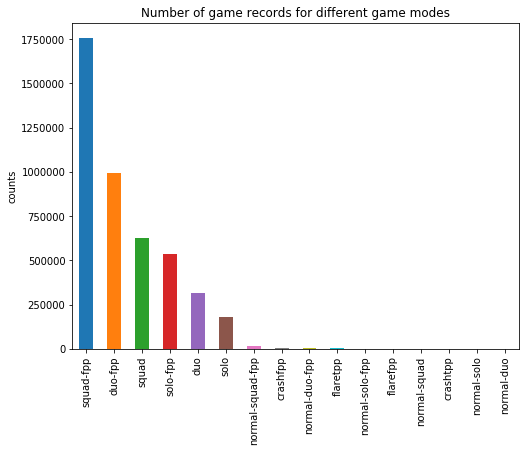

In [41]:
training_data["matchType"].value_counts().plot(kind="bar",figsize=(8,6))
plt.title("Number of game records for different game modes")
plt.ylabel("counts")

'squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', and 'solo' are standard PUBG games and the remaining types with low observation counts are only available in the custom game mode. We decided to combine all subtypes of custom games as a single category to make it more applicable for statistical analysis.

In [42]:
normal_type = ['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo']
training_data["matchType"] = [i if i in normal_type else "custom" for i in training_data["matchType"]]

Text(0,0.5,'counts')

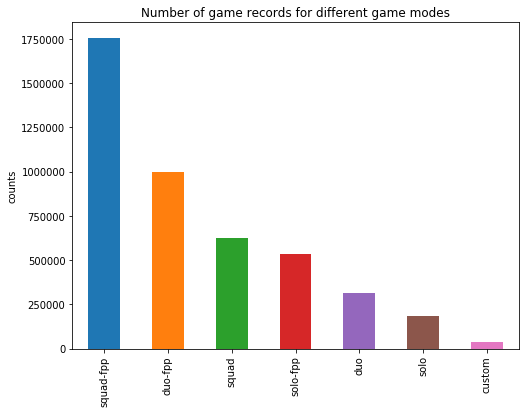

In [45]:
training_data["matchType"].value_counts().plot(kind="bar",figsize=(8,6))
plt.title("Number of game records for different game modes")
plt.ylabel("counts")

We will then explore distributions of the response varible for normal PUBG and custom PUBG games

Text(0,0.5,'counts')

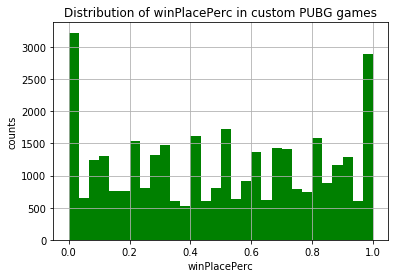

In [47]:
training_data[training_data["matchType"] == "custom"].winPlacePerc.hist(bins=30,color = "green")
plt.title("Distribution of winPlacePerc in custom PUBG games")
plt.xlabel("winPlacePerc")
plt.ylabel("counts")

Distribution of response variable for custom PUBG games is far from a uniform distribution

Text(0,0.5,'counts')

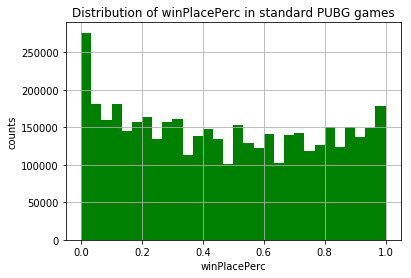

In [48]:
training_data[training_data["matchType"] != "custom"].winPlacePerc.hist(bins=30,color = "green")
plt.title("Distribution of winPlacePerc in standard PUBG games")
plt.xlabel("winPlacePerc")
plt.ylabel("counts")

Distribution of response varible for standard PUBG games fits a uniform distribution better but is still enriched in head area.

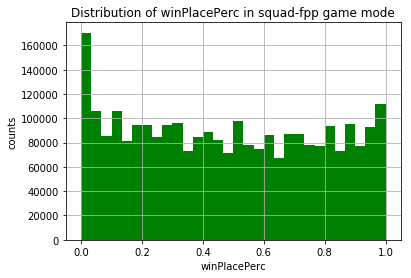

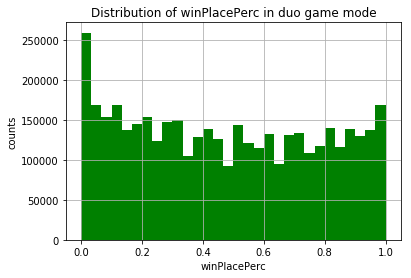

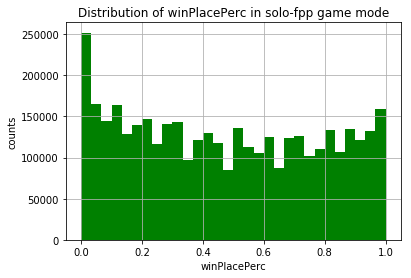

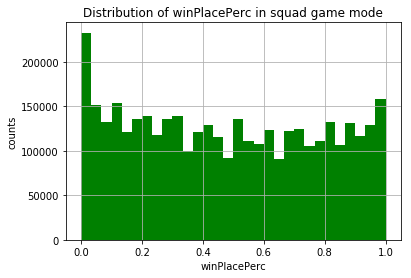

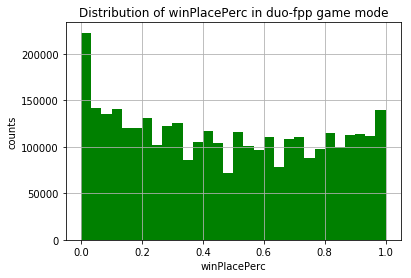

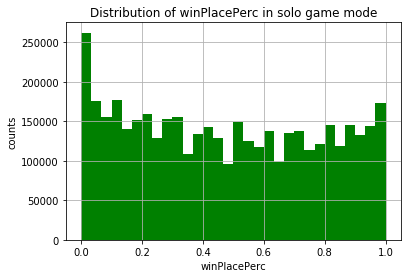

In [46]:
for i,t in enumerate(normal_type):
    plt.figure(i)
    training_data[training_data["matchType"] != t].winPlacePerc.hist(bins=30,color = "green")
    plt.title("Distribution of winPlacePerc in {} game mode".format(t))
    plt.xlabel("winPlacePerc")
    plt.ylabel("counts")

Above figures showed that the response variable of different subtypes of standard PUBG games follow a similar distribution pattern. They are all approximately uniformly distributed and are enriched in the head area.

In the original dataset, the first three columns (Id, matchId, and groupId) are identifiers which cannot be directly utilized in model construction. But with these identifiers, we can easily derive the following varibles which can be useful in model construction.
-  **groupsize**: total number of players of a group to which the game record belongs 
-  **maxgroupsize**: the maximum group size of the match to which the game record belongs
-  **matchsize**: total number of players of the match to which the game record belongs

In [49]:
training_data["groupsize"]= training_data.groupby("groupId").groupId.transform("count")
training_data['maxgroupsize'] = training_data.groupby('matchId').groupsize.transform("max")
training_data['matchsize'] = training_data.groupby('matchId').Id.transform('nunique')

In [50]:
training_data.shape

(4446965, 32)

We then check distributions of these newly generated varibles

Text(0.5,0,'group size')

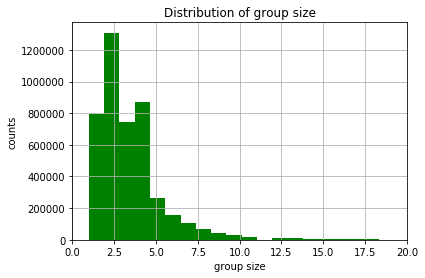

In [51]:
plt.hist(training_data['groupsize'],bins=80,color="green")
plt.title("Distribution of group size")
plt.xlim(0,20)
plt.grid(True)
plt.ylabel("counts")
plt.xlabel("group size")

For most of the observation records, their group sizes are distributed between 1 to 4, but there are still a great portion of game records whose group size is larger than 4. This may account for the enrichment of the target varible in the head area.

Text(0.5,0,'maximum group size')

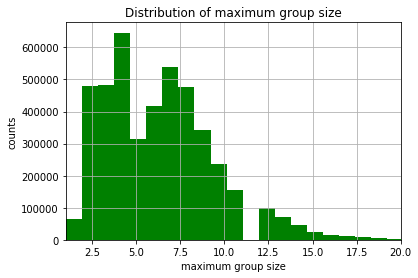

In [52]:
plt.hist(training_data['maxgroupsize'],bins=80,color="green")
plt.title("Distribution of maximum group size")
plt.xlim(1,20)
plt.grid(True)
plt.ylabel("counts")
plt.xlabel("maximum group size")

Distribution of maximum group size further confirmed that a large portion of matches contain groups whose group sizes are larger than four, even in standard PUBG games.

Text(0.5,0,'match size')

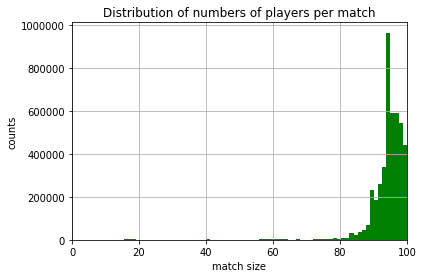

In [53]:
plt.hist(training_data['matchsize'],bins=80,color="green")
plt.title("Distribution of numbers of players per match")
plt.xlim(0,100)
plt.grid(True)
plt.ylabel("counts")
plt.xlabel("match size")

The distriibution of match size is as expected. Most of them are bewteen 80 to 100.

At this point, we no longer need those columns of identifiers

In [54]:
drop_columns = ["Id","groupId","matchId"]

In [55]:
training_data = training_data.drop(columns = drop_columns)

In [56]:
training_data.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'rankPoints',
       'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc', 'groupsize', 'maxgroupsize', 'matchsize'],
      dtype='object')

We then calculate correlations of continuous predictors and the target varible

Text(0.5,1,'Correlation matrix of continuous varibles')

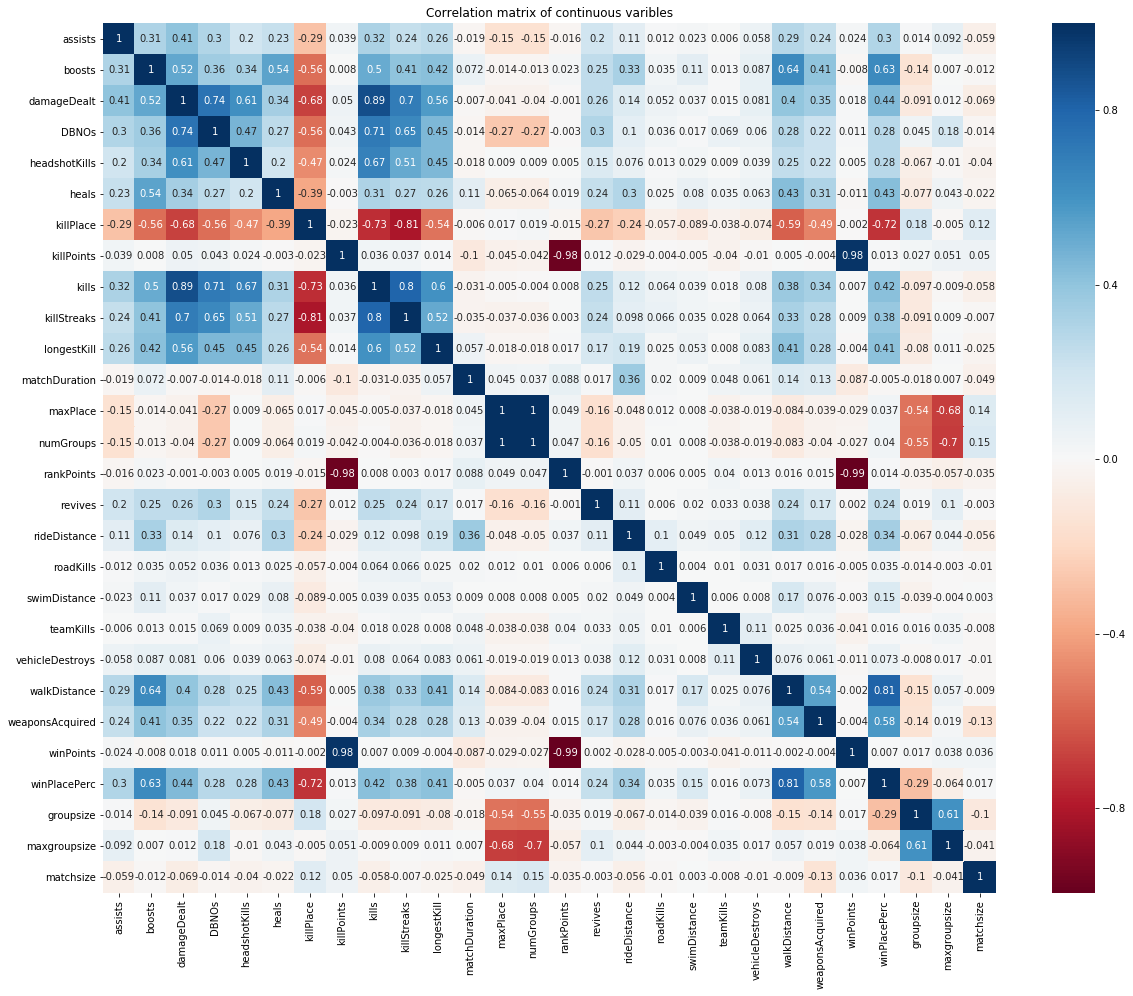

In [60]:
corr_matrix = training_data.corr()
corr_matrix= corr_matrix.round(decimals=3)
plt.figure(figsize=(20,16))
sns.heatmap(corr_matrix,annot=True, cmap="RdBu")
plt.title("Correlation matrix of continuous varibles")

In [61]:
corr_matrix["winPlacePerc"][:"winPoints"]

assists            0.299
boosts             0.634
damageDealt        0.441
DBNOs              0.280
headshotKills      0.278
heals              0.428
killPlace         -0.719
killPoints         0.013
kills              0.420
killStreaks        0.378
longestKill        0.410
matchDuration     -0.005
maxPlace           0.037
numGroups          0.040
rankPoints         0.014
revives            0.241
rideDistance       0.343
roadKills          0.035
swimDistance       0.150
teamKills          0.016
vehicleDestroys    0.073
walkDistance       0.811
weaponsAcquired    0.584
winPoints          0.007
Name: winPlacePerc, dtype: float64

Text(0.5,0,'predictors')

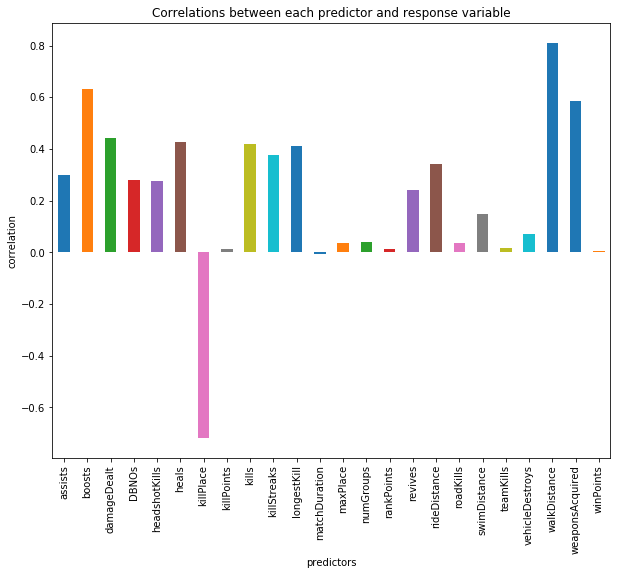

In [62]:
corr_matrix["winPlacePerc"][:"winPoints"].plot(kind="bar",figsize=(10,8))
plt.title("Correlations between each predictor and response variable")
plt.ylabel("correlation")
plt.xlabel("predictors")

All these continuous predictors are linearly correlated with the response variable to some degree.

For the only categorical variable, matchType ,we will convert it into multiple dummy varaibles before modeling. Since we have 7 categories, only 6 dummy varibles are needed, otherwise additional multicolinearity will be introduced

In [63]:
training_data["matchType"].unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'custom'], dtype=object)

In [64]:
dummies = pd.get_dummies(training_data["matchType"])
dummies= dummies.loc[:,"duo":]
training_data = pd.merge(dummies,training_data,left_index=True,right_index=True).drop(columns = "matchType")

In [65]:
training_data.shape

(4446965, 34)

In [66]:
training_data.columns

Index(['duo', 'duo-fpp', 'solo', 'solo-fpp', 'squad', 'squad-fpp', 'assists',
       'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace',
       'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration',
       'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired', 'winPoints', 'winPlacePerc',
       'groupsize', 'maxgroupsize', 'matchsize'],
      dtype='object')

## Data formatting & Feature engineering

Based on what we have mentioned in data exploration part, we will further reformat the original training and testing dataset before model construction

In [67]:
# A function to convert orginal data frame to a dataframe that is augmented with new features
def prepare_df(raw_df):
    raw_df = raw_df.dropna()
    normal_type = ['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo']
    raw_df["matchType"] = [i if i in normal_type else "custom" for i in raw_df["matchType"]]
    raw_df["groupsize"]= raw_df.groupby("groupId").groupId.transform("count")
    raw_df['maxgroupsize'] = raw_df.groupby('matchId').groupsize.transform("max")
    raw_df['matchsize'] = raw_df.groupby('matchId').Id.transform('nunique')
    dummies = pd.get_dummies(raw_df["matchType"])
    dummies= dummies.loc[:,"duo":]
    raw_df = pd.merge(dummies,raw_df,left_index=True,right_index=True).drop(columns = "matchType")
    drop_columns = ["Id","groupId","matchId"]
    final_df = raw_df.drop(columns=drop_columns)
    return final_df

In [68]:
training_data = prepare_df(raw_training_data)
testing_data = prepare_df(raw_testing_data)

/Users/chenwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/chenwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/chenwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

In [69]:
training_data.columns

Index(['duo', 'duo-fpp', 'solo', 'solo-fpp', 'squad', 'squad-fpp', 'assists',
       'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace',
       'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration',
       'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired', 'winPoints', 'winPlacePerc',
       'groupsize', 'maxgroupsize', 'matchsize'],
      dtype='object')

In [70]:
testing_data.columns

Index(['duo', 'duo-fpp', 'solo', 'solo-fpp', 'squad', 'squad-fpp', 'assists',
       'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace',
       'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration',
       'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys',
       'walkDistance', 'weaponsAcquired', 'winPoints', 'groupsize',
       'maxgroupsize', 'matchsize'],
      dtype='object')

We split the training dataset to into predictors and the response variable.

In [71]:
X_train = training_data.drop(columns="winPlacePerc")
y_train = training_data["winPlacePerc"]

In [72]:
X_train.shape

(4446965, 33)

In [73]:
y_train.shape

(4446965,)

In [74]:
X_test = testing_data

We then nomarlize all predictor columns of training and testing dataset as some machine learning techinques are sensitive to data scales 

In [75]:
minmax_scaler = MinMaxScaler()

In [76]:
X_train_n = minmax_scaler.fit_transform(X_train)

In [77]:
X_test_n = minmax_scaler.fit_transform(X_test)

In [78]:
y_train = np.array(y_train) # convert the response variable of training data to a numpy array 

In [79]:
y_train.shape

(4446965,)

In [80]:
X_train_n.shape

(4446965, 33)

In [81]:
X_test_n.shape

(1934174, 33)

## General linear regression

We will first consider building general linear regression models by 5-fold cross validation

In [112]:
kf = KFold(n_splits=5,random_state=9,shuffle=True)

### multivariate linear regression

In [113]:
X = X_train_n
y = y_train

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [115]:
for train_index, test_index in kf.split(X):
    X_train_, X_valid = X[train_index,], X[test_index,]
    y_train_, y_valid = y[train_index], y[test_index]
    lm = LinearRegression()
    lm.fit(X_train_,y_train_)
    y_pred = lm.predict(X_valid)
    mae = mean_absolute_error(y_pred=y_pred,y_true = y_valid)
    print("mean absolute error for this fold", mae)
    

mean absolute error for this fold 0.08879009259927949
mean absolute error for this fold 0.08870326374201044
mean absolute error for this fold 0.08861233276565345
mean absolute error for this fold 0.08867407785246573
mean absolute error for this fold 0.08882196923899874


As the model is validated by 5 fold cross validation, we then train a multivariate linear regression model with all normalized training data and get prediction results of testing data for submission

In [116]:
mlm = LinearRegression()
mlm.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [117]:
y_pred = mlm.predict(X_test_n)

Prepare the submission file

In [118]:
sub_df = pd.DataFrame(list(zip(record_ids,y_pred)),columns=["Id","winPlacePerc"])

In [119]:
sub_df.to_csv("submission_1.csv",index=False)

In [120]:
sub_df.head()

,Id,winPlacePerc
0,9329eb41e215eb,0.219155
1,639bd0dcd7bda8,1.102830
2,63d5c8ef8dfe91,0.539902
3,cf5b81422591d1,0.662030
4,ee6a295187ba21,1.195429


### Multivariate linear regression with interaction terms

We then fit a multilinear regression model by including interaction terms between predictors. Since we have over 4 million records in training data, we will sample 400,000 records to fit this model

In [129]:
np.random.seed(9)
sample_index = np.random.choice(X_train_n.shape[0],size=400000)

In [130]:
X = X_train_n[sample_index,]

In [131]:
y = y_train[sample_index]

In [132]:
X.shape

(400000, 33)

In [133]:
from sklearn.preprocessing import PolynomialFeatures

In [134]:
poly_transformer = PolynomialFeatures(degree=2,interaction_only=True)

In [135]:
X = poly_transformer.fit_transform(X)

In [143]:
X.shape

(400000, 562)

In [138]:
for train_index, test_index in kf.split(X):
    X_train_, X_valid = X[train_index,], X[test_index,]
    y_train_, y_valid = y[train_index], y[test_index]
    lm = LinearRegression()
    lm.fit(X_train_,y_train_)
    y_pred = lm.predict(X_valid)
    mae = mean_absolute_error(y_pred=y_pred,y_true = y_valid)
    print("mean absolute error for this fold", mae)

mean absolute error for this fold 0.06300996365341723
mean absolute error for this fold 0.06268522497648514
mean absolute error for this fold 0.06338503461671655
mean absolute error for this fold 0.06311204392237356
mean absolute error for this fold 0.06310729981703186


Train a model with all sampled 400000 records and apply the trained model on testing data

In [142]:
mlm_2 = LinearRegression()
mlm_2.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

As the testing data possesses over 1.9 million records, we will split it into 11 parts, and get results for each parts. Finally we will combine these results together. 

In [167]:
results =[]
for i in np.split(X_test_n,11,axis=0):
    results.append(mlm_2.predict(poly_transformer.fit_transform(i)))

In [181]:
y_pred_2 = np.concatenate(results)

In [182]:
sub_df_2 = pd.DataFrame(list(zip(record_ids,y_pred_2)),columns=["Id","winPlacePerc"])

In [186]:
sub_df_2.to_csv("submission_2.csv",index=False)

In [185]:
sub_df_2.head()

,Id,winPlacePerc
0,9329eb41e215eb,0.230696
1,639bd0dcd7bda8,0.898154
2,63d5c8ef8dfe91,0.640883
3,cf5b81422591d1,0.606778
4,ee6a295187ba21,1.064242


### Ridge regression (interaction terms included)

To adjust for overfitting, we regularize the former multivariate linear regression model by ridge regression

In [194]:
from sklearn.linear_model import Ridge

We would like to tune the alpha parameter (strength of regularization) using 5 fold cross validation

In [195]:
alpha_param = 10**(-np.arange(11,dtype="float"))

In [196]:
for alpha in alpha_param:
    mae_array = []
    for train_index, test_index in kf.split(X):
        X_train_, X_valid = X[train_index,], X[test_index,]
        y_train_, y_valid = y[train_index], y[test_index]
        ridge_lm = Ridge(alpha=alpha)
        ridge_lm.fit(X_train_,y_train_)
        y_pred = ridge_lm.predict(X_valid)
        mae = mean_absolute_error(y_pred=y_pred,y_true = y_valid)
        mae_array.append(mae)
    print("average of mean absolute error for alpha = {} is {}".format(alpha,np.mean(mae_array)))
    

average of mean absolute error for alpha = 1.0 is 0.0686198235512386
average of mean absolute error for alpha = 0.1 is 0.06449691113331403
average of mean absolute error for alpha = 0.01 is 0.0631616204723718
average of mean absolute error for alpha = 0.001 is 0.06305524233997527
average of mean absolute error for alpha = 0.0001 is 0.06305932398342429
average of mean absolute error for alpha = 1e-05 is 0.0630613639429784
average of mean absolute error for alpha = 1e-06 is 0.0630614496090263
average of mean absolute error for alpha = 1e-07 is 0.06306057268511327
average of mean absolute error for alpha = 1e-08 is 0.06305989366667114
average of mean absolute error for alpha = 1e-09 is 0.06305975286892702


/Users/chenwang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.137683e-17
  overwrite_a=True).T
/Users/chenwang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.352423e-17
  overwrite_a=True).T
/Users/chenwang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.601891e-17
  overwrite_a=True).T
/Users/chenwang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition numbe

average of mean absolute error for alpha = 1e-10 is 0.06305973716627636


Based on the result of cross validation, We will train a ridge regression model with alph=0.001 using 400000 sampled data

In [197]:
ridge_lm = Ridge(alpha=0.001)

In [198]:
ridge_lm.fit(X,y)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Apply the model on the testing dataset

In [199]:
results_ =[]
for i in np.split(X_test_n,11,axis=0):
    results_.append(ridge_lm.predict(poly_transformer.fit_transform(i)))

In [200]:
y_pred_3 = np.concatenate(results_)

In [201]:
sub_df_3 = pd.DataFrame(list(zip(record_ids,y_pred_3)),columns=["Id","winPlacePerc"])

In [203]:
sub_df_3.to_csv("submission_3.csv",index=False)

In [204]:
sub_df_3.head()

,Id,winPlacePerc
0,9329eb41e215eb,0.229911
1,639bd0dcd7bda8,0.902634
2,63d5c8ef8dfe91,0.640090
3,cf5b81422591d1,0.606701
4,ee6a295187ba21,1.064684


## Neuron network

Our next method is to utilize a simple (just two layers) neuron network model

In [205]:
from torch.autograd import Variable 
from torch.nn import functional as F
import torch

In [207]:
X_train_n.shape

(4446965, 33)

In [209]:
y_train.shape

(4446965,)

In [211]:
X_train_tensor = torch.from_numpy(X_train_n)
y_train_tensor = torch.from_numpy(y_train)

In [212]:
X_train_v = Variable(X_train_tensor)
y_train_v = Variable(y_train_tensor)

Change data type to float

In [216]:
X_train_v =X_train_v.float()
y_train_v = y_train_v.float()

In [223]:
y_train_v= y_train_v.reshape(y_train_v.shape[0],-1) # modify shape y_train_v

Define the structure of a neuron net work. Since the response varible is in [0,1], we will set the activation function as sigmoid.

In [219]:
class Net(torch.nn.Module): 
    def __init__(self, n_feature, n_hidden, n_output):
        super().__init__() 
        
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
 
    def forward(self, x):
        x = F.sigmoid(self.hidden(x))
        x = self.predict(x)
        return x

Create a model with the defined neuron net work

In [221]:
net= Net(33,50,1)

Define optomizer and loss function

In [222]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.005) 
loss_function = torch.nn.MSELoss() 

Model training with 300 epochs

In [225]:
for t in range(300):
    prediction = net(X_train_v) 
    loss = loss_function(prediction, y_train_v) 
    print ("loss of learning time {} is {}".format(t,loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 0 is 0.17104469239711761


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 1 is 0.15167002379894257


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 2 is 0.13728301227092743


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 3 is 0.12659868597984314


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 4 is 0.11866436898708344


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 5 is 0.11277168244123459


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 6 is 0.10839509218931198


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 7 is 0.10514423996210098


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 8 is 0.10272933542728424


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 9 is 0.10093507915735245


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 10 is 0.09960169345140457


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 11 is 0.0986105352640152


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 12 is 0.09787347912788391


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 13 is 0.09732510894536972


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 14 is 0.09691683202981949


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 15 is 0.09661256521940231


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 16 is 0.09638553112745285


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 17 is 0.09621583670377731


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 18 is 0.0960887148976326


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 19 is 0.09599320590496063


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 20 is 0.09592116624116898


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 21 is 0.09586654603481293


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 22 is 0.09582487493753433


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 23 is 0.09579280018806458


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 24 is 0.09576786309480667


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 25 is 0.09574822336435318


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 26 is 0.09573251008987427


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 27 is 0.09571972489356995


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 28 is 0.09570910036563873


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 29 is 0.09570008516311646


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 30 is 0.09569226950407028


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 31 is 0.09568533301353455


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 32 is 0.09567906707525253


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 33 is 0.09567328542470932


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 34 is 0.09566786140203476


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 35 is 0.09566271305084229


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 36 is 0.09565776586532593


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 37 is 0.09565296769142151


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 38 is 0.09564828127622604


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 39 is 0.09564367681741714


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 40 is 0.09563913196325302


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 41 is 0.09563463181257248


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 42 is 0.09563016146421432


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 43 is 0.09562572836875916


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 44 is 0.09562130272388458


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 45 is 0.0956168994307518


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 46 is 0.09561250358819962


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 47 is 0.09560811519622803


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 48 is 0.09560373425483704


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 49 is 0.09559936076402664


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 50 is 0.09559498727321625


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 51 is 0.09559061378240585


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 52 is 0.09558624774217606


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 53 is 0.09558188170194626


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 54 is 0.09557751566171646


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 55 is 0.09557315707206726


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 56 is 0.09556879103183746


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 57 is 0.09556443244218826


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 58 is 0.09556006640195847


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 59 is 0.09555570781230927


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 60 is 0.09555134922266006


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 61 is 0.09554699063301086


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 62 is 0.09554263204336166


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 63 is 0.09553827345371246


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 64 is 0.09553391486406326


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 65 is 0.09552956372499466


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 66 is 0.09552520513534546


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 67 is 0.09552084654569626


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 68 is 0.09551649540662766


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 69 is 0.09551213681697845


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 70 is 0.09550778567790985


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 71 is 0.09550343453884125


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 72 is 0.09549907594919205


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 73 is 0.09549472481012344


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 74 is 0.09549037367105484


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 75 is 0.09548602253198624


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 76 is 0.09548167139291763


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 77 is 0.09547732025384903


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 78 is 0.09547297656536102


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 79 is 0.09546862542629242


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 80 is 0.09546427428722382


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 81 is 0.09545992314815521


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 82 is 0.0954555794596672


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 83 is 0.0954512283205986


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 84 is 0.0954468846321106


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 85 is 0.09544254094362259


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 86 is 0.09543818980455399


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 87 is 0.09543384611606598


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 88 is 0.09542950242757797


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 89 is 0.09542515873908997


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 90 is 0.09542081505060196


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 91 is 0.09541647136211395


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 92 is 0.09541212767362595


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 93 is 0.09540778398513794


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 94 is 0.09540344029664993


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 95 is 0.09539910405874252


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 96 is 0.09539476037025452


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 97 is 0.09539041668176651


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 98 is 0.0953860804438591


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 99 is 0.09538174420595169


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 100 is 0.09537740051746368


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 101 is 0.09537306427955627


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 102 is 0.09536872804164886


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 103 is 0.09536438435316086


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 104 is 0.09536004811525345


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 105 is 0.09535571187734604


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 106 is 0.09535137563943863


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 107 is 0.09534703940153122


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 108 is 0.0953427106142044


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 109 is 0.095338374376297


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 110 is 0.09533403813838959


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 111 is 0.09532970190048218


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 112 is 0.09532537311315536


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 113 is 0.09532103687524796


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 114 is 0.09531670808792114


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 115 is 0.09531237185001373


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 116 is 0.09530804306268692


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 117 is 0.09530371427536011


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 118 is 0.0952993854880333


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 119 is 0.09529505670070648


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 120 is 0.09529072791337967


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 121 is 0.09528639167547226


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 122 is 0.09528207033872604


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 123 is 0.09527774155139923


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 124 is 0.09527341276407242


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 125 is 0.0952690839767456


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 126 is 0.09526475518941879


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 127 is 0.09526043385267258


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 128 is 0.09525610506534576


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 129 is 0.09525178372859955


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 130 is 0.09524745494127274


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 131 is 0.09524313360452652


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 132 is 0.0952388122677803


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 133 is 0.09523448348045349


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 134 is 0.09523016214370728


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 135 is 0.09522584080696106


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 136 is 0.09522151947021484


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 137 is 0.09521719813346863


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 138 is 0.09521287679672241


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 139 is 0.0952085554599762


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 140 is 0.09520423412322998


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 141 is 0.09519992023706436


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 142 is 0.09519559890031815


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 143 is 0.09519127756357193


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 144 is 0.09518696367740631


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 145 is 0.0951826423406601


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 146 is 0.09517832845449448


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 147 is 0.09517400711774826


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 148 is 0.09516969323158264


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 149 is 0.09516537934541702


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 150 is 0.0951610654592514


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 151 is 0.09515675157308578


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 152 is 0.09515243023633957


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 153 is 0.09514812380075455


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 154 is 0.09514380991458893


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 155 is 0.09513949602842331


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 156 is 0.09513518214225769


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 157 is 0.09513086825609207


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 158 is 0.09512655436992645


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 159 is 0.09512224793434143


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 160 is 0.09511793404817581


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 161 is 0.09511362761259079


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 162 is 0.09510931372642517


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 163 is 0.09510500729084015


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 164 is 0.09510070085525513


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 165 is 0.09509638696908951


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 166 is 0.09509208053350449


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 167 is 0.09508777409791946


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 168 is 0.09508346766233444


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 169 is 0.09507916122674942


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 170 is 0.0950748547911644


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 171 is 0.09507054835557938


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 172 is 0.09506624191999435


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 173 is 0.09506193548440933


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 174 is 0.09505763649940491


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 175 is 0.09505333006381989


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 176 is 0.09504902362823486


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 177 is 0.09504472464323044


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 178 is 0.09504041820764542


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 179 is 0.09503611922264099


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 180 is 0.09503182023763657


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 181 is 0.09502751380205154


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 182 is 0.09502321481704712


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 183 is 0.0950189158320427


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 184 is 0.09501461684703827


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 185 is 0.09501031786203384


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 186 is 0.09500601887702942


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 187 is 0.095001719892025


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 188 is 0.09499742090702057


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 189 is 0.09499312192201614


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 190 is 0.09498882293701172


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 191 is 0.09498453140258789


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 192 is 0.09498023241758347


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 193 is 0.09497594088315964


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 194 is 0.09497164189815521


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 195 is 0.09496735036373138


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 196 is 0.09496305137872696


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 197 is 0.09495875984430313


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 198 is 0.0949544683098793


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 199 is 0.09495016932487488


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 200 is 0.09494587779045105


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 201 is 0.09494158625602722


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 202 is 0.0949372947216034


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 203 is 0.09493300318717957


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 204 is 0.09492871165275574


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 205 is 0.09492442011833191


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 206 is 0.09492012858390808


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 207 is 0.09491584450006485


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 208 is 0.09491155296564102


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 209 is 0.0949072614312172


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 210 is 0.09490297734737396


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 211 is 0.09489868581295013


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 212 is 0.0948944017291069


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 213 is 0.09489011019468307


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 214 is 0.09488582611083984


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 215 is 0.09488154202699661


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 216 is 0.09487725794315338


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 217 is 0.09487296640872955


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 218 is 0.09486868232488632


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 219 is 0.09486439824104309


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 220 is 0.09486011415719986


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 221 is 0.09485583007335663


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 222 is 0.0948515459895134


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 223 is 0.09484726190567017


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 224 is 0.09484298527240753


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 225 is 0.0948387011885643


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 226 is 0.09483441710472107


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 227 is 0.09483014047145844


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 228 is 0.0948258563876152


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 229 is 0.09482157975435257


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 230 is 0.09481729567050934


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 231 is 0.0948130190372467


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 232 is 0.09480874240398407


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 233 is 0.09480445832014084


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 234 is 0.0948001816868782


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 235 is 0.09479590505361557


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 236 is 0.09479162842035294


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 237 is 0.0947873517870903


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 238 is 0.09478307515382767


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 239 is 0.09477879852056503


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 240 is 0.0947745218873024


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 241 is 0.09477024525403976


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 242 is 0.09476596862077713


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 243 is 0.09476169943809509


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 244 is 0.09475742280483246


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 245 is 0.09475315362215042


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 246 is 0.09474887698888779


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 247 is 0.09474460035562515


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 248 is 0.09474033117294312


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 249 is 0.09473606199026108


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 250 is 0.09473178535699844


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 251 is 0.0947275161743164


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 252 is 0.09472324699163437


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 253 is 0.09471897780895233


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 254 is 0.0947147086262703


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 255 is 0.09471043944358826


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 256 is 0.09470617026090622


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 257 is 0.09470190107822418


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 258 is 0.09469763189554214


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 259 is 0.09469336271286011


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 260 is 0.09468909353017807


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 261 is 0.09468483179807663


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 262 is 0.09468056261539459


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 263 is 0.09467629343271255


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 264 is 0.09467203170061111


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 265 is 0.09466776251792908


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 266 is 0.09466350078582764


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 267 is 0.0946592316031456


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 268 is 0.09465496987104416


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 269 is 0.09465070813894272


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 270 is 0.09464644640684128


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 271 is 0.09464217722415924


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 272 is 0.0946379154920578


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 273 is 0.09463365375995636


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 274 is 0.09462939202785492


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 275 is 0.09462513029575348


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 276 is 0.09462086856365204


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 277 is 0.0946166142821312


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 278 is 0.09461235255002975


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 279 is 0.09460809081792831


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 280 is 0.09460382908582687


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 281 is 0.09459957480430603


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 282 is 0.09459531307220459


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 283 is 0.09459105879068375


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 284 is 0.0945867970585823


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 285 is 0.09458254277706146


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 286 is 0.09457828104496002


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 287 is 0.09457402676343918


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 288 is 0.09456977248191833


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 289 is 0.09456551820039749


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 290 is 0.09456125646829605


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 291 is 0.09455700218677521


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 292 is 0.09455274790525436


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 293 is 0.09454849362373352


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 294 is 0.09454423934221268


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 295 is 0.09453998506069183


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 296 is 0.09453573822975159


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 297 is 0.09453148394823074


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 298 is 0.0945272296667099


/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss of learning time 299 is 0.09452297538518906


Save the trained nn

In [226]:
torch.save(net.state_dict(), "./33_feature_nn.pt")

Apply the trained nn on testing set

In [229]:
y_pred_4 = net(Variable(torch.from_numpy(X_test_n)).float())

/Users/chenwang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [255]:
sub_df_4 = pd.DataFrame(list(zip(record_ids,[i[0] for i in list(np.array(y_pred_4.detach()))])),columns=["Id","winPlacePerc"])

In [258]:
sub_df_4.to_csv("submission_4.csv",index=False)

In [256]:
sub_df_4.head()

,Id,winPlacePerc
0,9329eb41e215eb,0.471595
1,639bd0dcd7bda8,0.442499
2,63d5c8ef8dfe91,0.471110
3,cf5b81422591d1,0.444896
4,ee6a295187ba21,0.468370


# Kaggle Results

We then run this notebook in a kaggle kernel, and obtain evaluations of our predicted results using four different models respectively. The smaller the score is, the better a model performs

![Kaggle results](./kaggle_result.png)

Models and socres utilized for submission are (oldest to newest): 
-   Multivariate linear regression (all training data): 0.1270
-   Multivariate linear regression with interaction terms (10% training data): 37.3166
-   Multivariate ridge regression with interaction terms (10% training data): 0.0786
-   two layer neuron net work (all training data): 0.2646


# Conclusions

We utilized a sequence of four models to solve this kaggle PUBG final placement prediction problem. The original dataset have a feature space of 28 features. We augmented the feature space by deriving 3 additional features (groupsize,maxgroupsize,matchsize) from identifier columns. Then we convert the matchType column, a categorical varible, into 6 dummy variables. After removing those redundant columns, the final feature space holds 33 features.

Using the augmented training data we constructed four models:

-   Multivariate linear regression (all training data)
-   Multivariate linear regression with interaction terms (10% training data)
-   Multivariate ridge regression with interaction terms (10% training data)
-   two layer neuron net work (all training data)

Final result showed that the ridge regression model including feature interaction terms was the best, even it was just trained by 10% of the orginal training data. We think that the intensively large bias for the multivariate linear regression model which included interaction terms was due to overfit.

The neuron net work doen't work very well since we just defined two layers. If more computation power allowed, we may implement a more complex neuron network, and we anticipate that it should perform the best.